In [80]:
import joblib
import pandas as pd
from tqdm import tqdm 
import numpy as np
from xgboost import XGBRegressor,XGBClassifier
import warnings
warnings.simplefilter(action='ignore')

def load_data(path):
    data = joblib.load(path)
    return data

def reorganize_data(data):
    total_x_train = []
    total_y_train = []
    for i in tqdm(data):
        temp_train = data[i]['train'] 
        temp_target = data[i]['target']
        temp_x = temp_train.iloc[0:int(len(temp_train)*0.5)]
        temp_y = temp_target.iloc[0:int(len(temp_target)*0.5)]
        total_x_train.append(temp_x)
        total_y_train.append(temp_y)
    x_df = pd.concat(total_x_train)
    y_df = pd.concat(total_y_train)
    return x_df,y_df

def universal_algo(x_df,y_df ):
    return_regr  = XGBRegressor(n_estimators=50, max_depth=7, learning_rate=0.3,
                       verbosity = 1,subsample =0.5)
    return_regr.fit(x_df,y_df['future_return'])

    ev_regr  = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1,
                       verbosity = 1,subsample =0.8)
    ev_regr.fit(x_df,y_df['future_ev'])

    sharpe_regr  = XGBRegressor(n_estimators=50, max_depth=7, learning_rate=0.3,
                       verbosity = 1,subsample =0.5)
    sharpe_regr.fit(x_df,y_df['future_sharpe'])

    xgb_triple = y_df['future_triplebarrier_label']
    xgb_triple.iloc[xgb_triple == -1] = 2
    triple_bar_clf = XGBClassifier(n_estimators=50, max_depth=7, learning_rate=0.3,
                       verbosity = 1,subsample =0.5)
    triple_bar_clf.fit(x_df,y_df['future_triplebarrier_label'])
    
    
    return return_regr,ev_regr,sharpe_regr,triple_bar_clf




unified_data = load_data('preprocessed_data.pkl')
#x_df,y_df = reorganize_data(unified_data)
return_regr,ev_regr,sharpe_regr,triple_bar_clf = universal_algo(x_df,y_df )

#return_regr,ev_regr,sharpe_regr,triple_bar_clf = joblib.load('model.pkl')





[20:13:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [81]:
for symbol in unified_data:
    symbol_data = unified_data[symbol]
    if len(symbol_data['price'])  < 100:
        continue


    symbol_data['price']['xgb_return'] = return_regr.predict(symbol_data['train'])
    symbol_data['price']['xgb_ev'] = ev_regr.predict(symbol_data['train'])
    symbol_data['price']['xgb_sharpe'] = sharpe_regr.predict(symbol_data['train'])
    symbol_data['price']['xgb_triple'] = [i[1] for i in triple_bar_clf.predict_proba(symbol_data['train'])]
    symbol_data['price']['8hr_return'] = (symbol_data['price']['Close'].shift(-8) - symbol_data['price']['Open'].shift(-1)) / symbol_data['price']['Open'].shift(-1)

    
    
    

In [82]:
unified_data['BTC/USDT:USDT']['price']

,index,Open,High,Low,Close,Volume,symbol,interval,1day_return,xgb_return,xgb_ev,xgb_sharpe,xgb_triple,8hr_return
Timestamp,,,,,,,,,,,,,,
1706374800000,238,41780.6,41828.1,41752.0,41758.1,868.430,BTC/USDT:USDT,1h,0.000357,0.009853,0.002340,-0.136688,0.729033,0.007563
1706378400000,239,41758.1,41796.9,41720.7,41773.0,697.965,BTC/USDT:USDT,1h,0.002645,0.005373,0.002340,-0.128708,0.551248,0.007263
1706382000000,240,41773.0,41975.0,41766.9,41883.5,2399.735,BTC/USDT:USDT,1h,0.003734,0.007076,0.002624,-0.053740,0.382862,0.007655
1706385600000,241,41883.5,42060.9,41883.5,42039.9,2632.801,BTC/USDT:USDT,1h,0.002024,0.008931,0.002626,0.020774,0.176942,0.015971
1706389200000,242,42039.9,42166.9,41999.2,42125.0,2519.194,BTC/USDT:USDT,1h,-0.000009,0.008599,0.002540,0.093273,0.252261,0.009709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709154000000,983,60450.3,60669.4,59811.7,60613.0,8851.049,BTC/USDT:USDT,1h,0.011656,-0.012631,0.008252,0.527862,0.548398,NaN
1709157600000,984,60613.0,61438.0,60560.4,61319.5,7565.546,BTC/USDT:USDT,1h,0.018992,-0.016032,0.007211,0.219050,0.256848,NaN
1709161200000,985,61319.5,62713.0,61310.0,62484.1,14132.617,BTC/USDT:USDT,1h,-0.016915,-0.014722,0.008540,0.747903,0.645372,NaN


In [83]:
def get_max_columns(row, n):
    top_n_values = row.nlargest(n).index
    for i, col in enumerate(top_n_values):
        row[f'top_{i+1}'] = col
    return row

def get_return_columns(row, return_df):
    t = row.values
    
    r_8 = np.mean([return_df.loc[row.name,i] for i in t])
    return r_8


ranking_df = pd.DataFrame()
period_return_df = pd.DataFrame()
for symbol in unified_data:
    if unified_data[symbol]['price'].empty or len(unified_data[symbol]['price']) < 100:
        continue
    #print(unified_data[symbol]['price'])
    try:
        ranking_df[symbol] = unified_data[symbol]['price']['xgb_return']
        period_return_df[symbol] = unified_data[symbol]['price']['8hr_return']
    except:
        #print(unified_data[symbol]['price'])
        df = unified_data[symbol]['price']
        print(df[df.index.duplicated()])


        raise Exception

targeted_df = pd.DataFrame()
top_n_values = 5
# Apply the function to each row
targeted_df = ranking_df.apply(lambda row: get_max_columns(row, top_n_values), axis=1)[[ f'top_{i+1}' for i in range(top_n_values)]]

targeted_return_df =  pd.DataFrame()
targeted_return_df['return'] = targeted_df.apply(lambda row :  get_return_columns(row, period_return_df), axis=1 )
targeted_return_df.set_index(pd.to_datetime(targeted_return_df.index,unit = 'ms'), inplace =True )



<AxesSubplot:xlabel='Timestamp'>

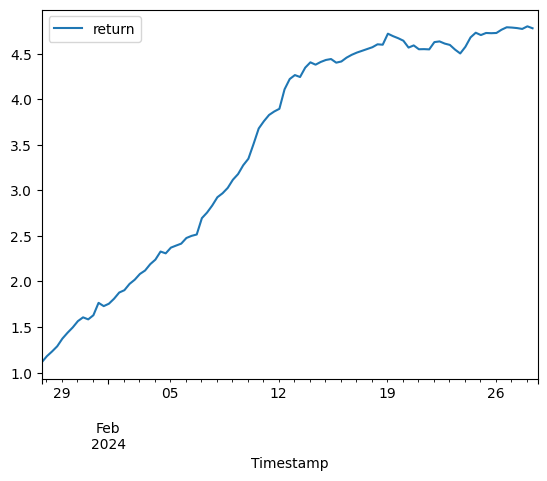

In [84]:
(1+targeted_return_df[::8].cumsum()).plot()


In [ ]:
targeted_df

In [53]:
import ccxt

In [54]:
def get_ohlcv(symbol,interval,mode ='all'):
    ex = ccxt.bybit()
    page = 10
    if mode == 'all':
        page = 100
    elif  mode == 'update':
        page = 1
        
    data  = ex.fetch_ohlcv(symbol, interval, limit=1000 , params = {"paginate": True})
    
    for i in range:
        symbol = None  # change for your symbol
        since = None
        limit = 20  # change for your limit
        params = {
            'cursor': cursor,  # exchange-specific non-unified parameter name
        }
        orders =  exchange.fetch_orders(symbol, since, limit, params)
        if len(orders):
            # not thread-safu and exchange-specific !
            cursor = exchange.last_response_headers['CB-AFTER']
            all_orders += orders
        else:
            break

            
            
            
            
    df = pd.DataFrame(data, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['symbol'] = symbol
    df['interval'] = interval

    return df


In [60]:
u = get_ohlcv('BTC/USDT:USDT','1h','update')

In [61]:
u.set_index('Timestamp',inplace = True)
u= u[~u.index.duplicated()]

In [62]:
u

,Open,High,Low,Close,Volume,symbol,interval
Timestamp,,,,,,,
1705694400000,41830.1,42199.0,41525.4,41643.1,9827.170,BTC/USDT:USDT,1h
1705698000000,41643.1,41806.0,41558.0,41640.2,4736.233,BTC/USDT:USDT,1h
1705701600000,41640.2,41744.7,41542.0,41689.3,1870.473,BTC/USDT:USDT,1h
1705705200000,41689.3,41727.2,41612.7,41663.0,1297.357,BTC/USDT:USDT,1h
1705708800000,41663.0,41685.7,41412.6,41482.1,4646.001,BTC/USDT:USDT,1h
...,...,...,...,...,...,...,...
1709276400000,61619.6,61847.2,61440.0,61494.0,3982.332,BTC/USDT:USDT,1h
1709280000000,61494.0,62324.0,61366.0,61968.1,8036.809,BTC/USDT:USDT,1h
1709283600000,61968.1,62314.9,61925.2,62210.1,4393.172,BTC/USDT:USDT,1h


In [67]:
n = get_ohlcv('BTC/USDT:USDT','1h','all')

In [68]:
n.set_index('Timestamp',inplace = True)
n= u[~u.index.duplicated()]

In [69]:
n

,Open,High,Low,Close,Volume,symbol,interval
Timestamp,,,,,,,
1705694400000,41830.1,42199.0,41525.4,41643.1,9827.170,BTC/USDT:USDT,1h
1705698000000,41643.1,41806.0,41558.0,41640.2,4736.233,BTC/USDT:USDT,1h
1705701600000,41640.2,41744.7,41542.0,41689.3,1870.473,BTC/USDT:USDT,1h
1705705200000,41689.3,41727.2,41612.7,41663.0,1297.357,BTC/USDT:USDT,1h
1705708800000,41663.0,41685.7,41412.6,41482.1,4646.001,BTC/USDT:USDT,1h
...,...,...,...,...,...,...,...
1709276400000,61619.6,61847.2,61440.0,61494.0,3982.332,BTC/USDT:USDT,1h
1709280000000,61494.0,62324.0,61366.0,61968.1,8036.809,BTC/USDT:USDT,1h
1709283600000,61968.1,62314.9,61925.2,62210.1,4393.172,BTC/USDT:USDT,1h
